In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import gmaps
import os
from api_keys import g_key
from api_keys import weather_api_key

In [2]:
total_2020=pd.read_csv("../cleaned_csvs/cle_flights_2020.csv", parse_dates=["FL_DATE"])
data_2020_reduced=total_2020[["FL_DATE", "ORIGIN", "DEST", "DEST_CITY_NAME"]]
data_2020_departures=data_2020_reduced.loc[data_2020_reduced["ORIGIN"]=="CLE"]
data_2020_departures['FL_DATE'] = pd.to_datetime(data_2020_departures['FL_DATE']).dt.date
data_2020_departures

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,FL_DATE,ORIGIN,DEST,DEST_CITY_NAME
15,2020-01-31,CLE,ATL,"Atlanta, GA"
16,2020-01-31,CLE,BNA,"Nashville, TN"
17,2020-01-31,CLE,BNA,"Nashville, TN"
18,2020-01-31,CLE,BWI,"Baltimore, MD"
19,2020-01-31,CLE,BWI,"Baltimore, MD"
...,...,...,...,...
22532,2020-03-11,CLE,ORD,"Chicago, IL"
22534,2020-03-11,CLE,DEN,"Denver, CO"
22536,2020-03-11,CLE,ORD,"Chicago, IL"
22537,2020-03-11,CLE,SFO,"San Francisco, CA"


In [3]:
data_2020_departures["DEST"].value_counts()[0:5]
top_dest=data_2020_departures.loc[(data_2020_departures["DEST"]=="ORD") | (data_2020_departures["DEST"]=="LGA") |
                                  (data_2020_departures["DEST"]=="ATL") | (data_2020_departures["DEST"]=="CLT") |
                                  (data_2020_departures["DEST"]=="BOS"), :]
len(top_dest["FL_DATE"].unique())

                                  

91

In [16]:
import time
mean_temp=[] 
dates=[]
cities=[]
cities_final=[]
dates_final=[]
for index, row in top_dest.iterrows():
    city=row["DEST_CITY_NAME"].split("/",)
    date=row["FL_DATE"]
    if city not in cities:
        cities.append(city)
    if date not in dates: 
        dates.append(date)

for city in cities:
    for date in dates: 
        response = requests.get(f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key={weather_api_key}&q={city[0]}&format=json&date={date}").json()
        cities_final.append(city)
        dates_final.append(date)
        mean_temp.append(response["data"]["weather"][0]["avgtempF"]) 

In [17]:
temp_df=pd.DataFrame({"CITY":cities_final,"DATE":dates_final,"TEMP":mean_temp})

In [138]:
cle_temp=[]
for index, row in data_2020_departures.head().iterrows():
    date=row["FL_DATE"]
    response = requests.get(f"http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=b569a70f43cc4efc9f602629202306&q=Cleveland&format=json&date={date}").json()
    cle_temp.append(response["data"]["weather"][0]["avgtempF"])

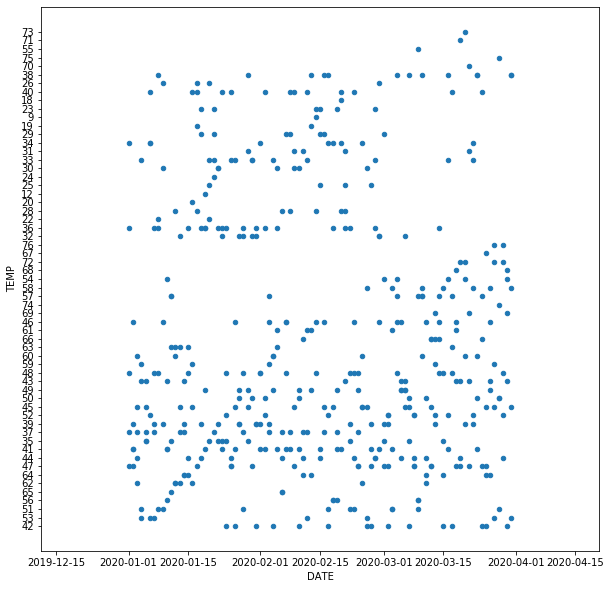

In [29]:
temp_df.plot(x="DATE", y="TEMP", kind="scatter", figsize=(10,10))

In [25]:

temp=temp_df["TEMP"].astype(int)
quartiles = temp.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of temperatures is: {lowerq}")
print(f"The upper quartile of temperatures is: {upperq}")
print(f"The interquartile range of temperatures is: {iqr}")
print(f"The the median of temperatures is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of temperatures is: 37.0
The upper quartile of temperatures is: 52.0
The interquartile range of temperatures is: 15.0
The the median of temperatures is: 44.0 
Values below 14.5 could be outliers.
Values above 74.5 could be outliers.


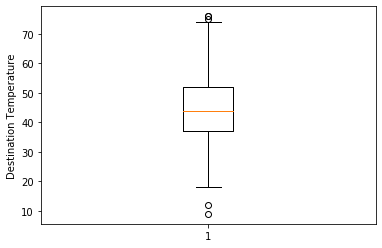

In [35]:
temp=temp_df["TEMP"].astype(int)
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Destination Temperature')
ax1.boxplot(temp)
plt.show()